In [14]:
import kex_headers
import numpy as np
import matplotlib.pyplot as plt
import representation
import importlib
importlib.reload(representation);
import time

In [2]:
def check_cycle(x, f, f_back, tol=1e-6, verbose=False):
    y = f(x)
    cycled_x = f_back(y)
    if verbose:
        if (np.ndim(x) == 1) and (np.ndim(y) == 1):
            ncols=2
            fig, axes = plt.subplots(ncols=ncols, figsize=(15,5))
            for ax, vlabel, value in zip(axes, ['y', "cycled x"], [y, cycled_x]):
                ax.plot(x,value)
                ax.set_xlabel('x')
                ax.set_ylabel(vlabel)
            plt.show()
                
        print("x", x)
        print("y", y)
        print("cycled x", cycled_x)
    error = np.abs(cycled_x - x)
    if np.all(error < tol):
        print('test passed')
    else:
        print('error')
        print("ratio", np.sum(error)/np.size(error))

In [3]:
seg_sizes = kex_headers.SEGMENT_TABLE
def mi_f(x):
    return representation.untangle_mi(x, seg_sizes)

def mi_f_back(x):
    return representation.get_mi(*x, seg_sizes)

In [4]:
print('testing mi')
mi = np.arange(kex_headers.NUMBER_OF_SINOGRAMS)
check_cycle(mi, mi_f, mi_f_back)

testing mi
test passed


In [5]:
scan_info = kex_headers.SCAN_DICT
kwargs = {'ro_rad': scan_info['ro rad'], 
            'radius': scan_info['radius'],
             'ro_size': scan_info['ro size']}
def ro_f(x):
    return representation.arc_radial_offset(**kwargs)

def ro_back(x):
    return representation.arc_ro_bin(x, **kwargs)

testing arced radial offset


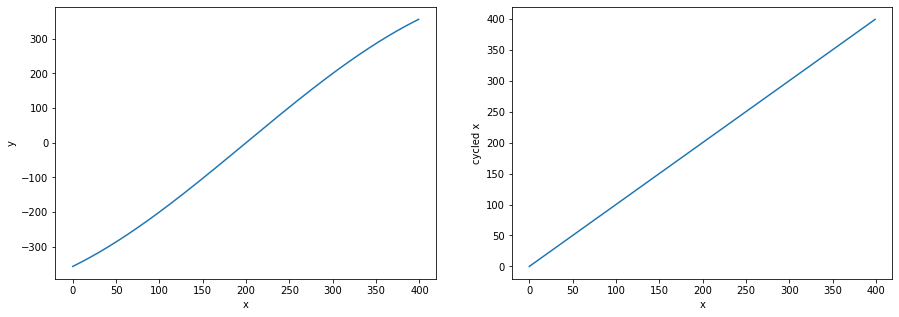

x [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 

In [6]:
print('testing arced radial offset')
ro = np.arange(kex_headers.NUMBER_OF_PROJECTIONS)
check_cycle(ro, ro_f, ro_back, verbose=True)

In [7]:
def omap_f(x):
    return representation.get_offset_map(len(x))

g_omap = representation.get_offset_map_inverse

def omap_back(x):
    return g_omap(len(x))[x]

In [8]:
print('testing omap')
for size in range(15):
    print("size", size)
    check_cycle(np.arange(size), omap_f, omap_back)

testing omap
size 0
test passed
size 1
test passed
size 2
error
ratio 0.5
size 3
test passed
size 4
error
ratio 0.75
size 5
test passed
size 6
error
ratio 0.8333333333333334
size 7
test passed
size 8
error
ratio 0.875
size 9
test passed
size 10
error
ratio 0.9
size 11
test passed
size 12
error
ratio 0.9166666666666666
size 13
test passed
size 14
error
ratio 0.9285714285714286


In [9]:
def o_f(x):
    return representation.get_offset(x)

def o_back(x):
    return representation.get_offset_bin(x)

In [10]:
print('testing offset')
check_cycle(np.arange(14), o_f, o_back)

testing offset
test passed


In [11]:
print('testing natural bin')
g = representation.get_natural_toflor_units
def f(x):
    return g(x, kex_headers.SCAN_DICT)

h = representation.get_toflor_bins
def f_back(x):
    return h(x,kex_headers.SCAN_DICT)[0] #do not return "is_fov"

print('zeros')
toflor = np.zeros((4,6), dtype=int)
check_cycle(toflor, f, f_back)
print('samples')
time_a = time.time()
meshes = np.mgrid[0:13, 0:621:30, 0:168, 0:400]
print(meshes.shape)
toflor = [mesh.flatten().astype(int) for mesh in meshes]
check_cycle(toflor, f, f_back)
print('elapsed time', time.time()-time_a)
print('N=', len(toflor[0]))

testing natural bin
zeros
test passed
samples
(4, 13, 21, 168, 400)
test passed
elapsed time 10.659491777420044
N= 18345600


In [12]:
g_move = representation.move_translation_projection
translation = np.array([1,1,1])
def move_f(x):
    new_toflor, is_fov = g_move(x, translation)
    return new_toflor

def move_back(x):
    new_toflor, is_fov = g_move(x, -translation)
    return new_toflor

In [70]:
print('testing move toflor')
print('translating by xyz', translation)
tof = 0
tof_size = 13+1
mi = 0
mi_size = 621
ro = 200
ro_size = 400
tx = 80
tx_size = 168

meshes = np.mgrid[tof:tof+1, mi:mi+1, tx:tx+10, 10:ro_size-10]
print("samples", meshes.shape)
toflor = [mesh.flatten().astype(int) for mesh in meshes]
check_cycle(toflor, move_f, move_back)

testing move toflor
translating by xyz [1 1 1]
samples (4, 1, 1, 10, 380)
error
ratio 0.0006578947368421052


In [71]:
x = toflor
y = move_f(x)
cycled_x = move_back(y)

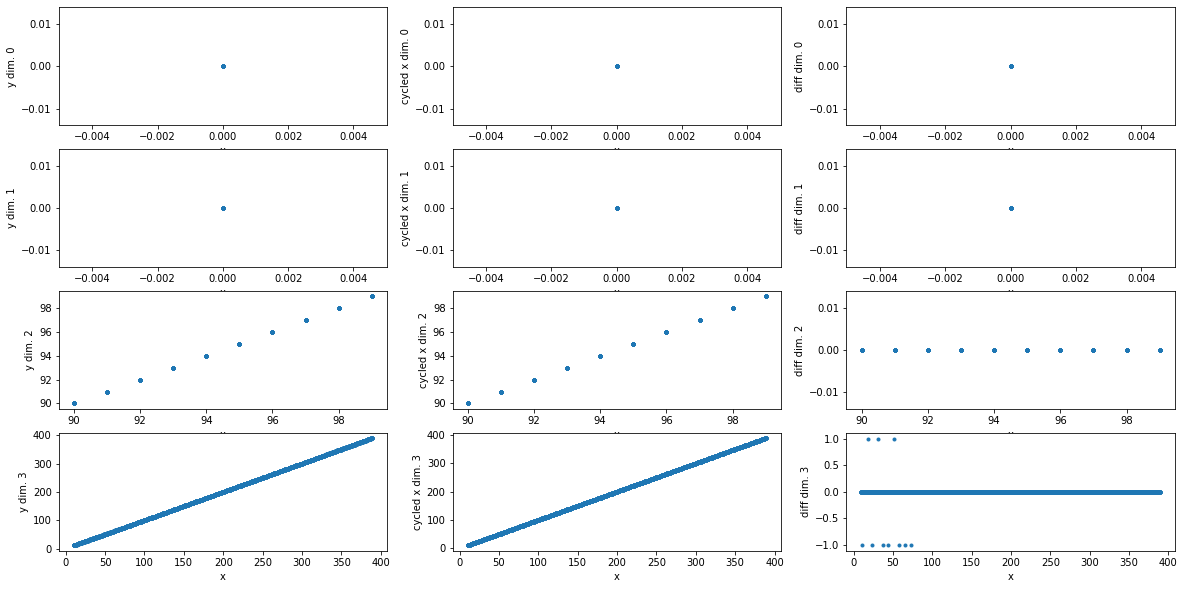

In [72]:
ys = [y, cycled_x, x-cycled_x]
ylabels = ['y', "cycled x", 'diff']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,10))
for dim, row in enumerate(axes):
    for ax, v, vlabel in zip(row, ys, ylabels):
        ax.scatter(x[dim], v[dim], marker = '.')
        ax.set_xlabel('x')
        ax.set_ylabel("{} dim. {}".format(vlabel, dim))
plt.show()

In [ ]:
# ro needs special treatment
# arc correction, scaled to mm
# center 
#
# rm, segment extracted from mi
#   center
#   segment bin to offset
#   scale with span
#   scaled to mm
#   
#
# tof bin converted to offset
#     scaled to time
#     center
#     scale with flightspeed
#     halve
#
# could detector pair be useful / simplify ?
#     radial offset "angle" would not simplified,
#     ro angle is relative to the transaxial angle
#             any of the pair would do though
#     transaxial angle would not be simplified
#